In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from scipy import stats
from sklearn.model_selection import cross_val_score

### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

In [3]:
# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [4]:
params = {'n_estimators': 500,
              'max_depth': 4,
              'loss': 'exponential'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)
        
# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.0231860338243317
Percent Type II errors: 0.12302236770321877

Test set accuracy:
Percent Type I errors: 0.08711656441717791
Percent Type II errors: 0.18159509202453988


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

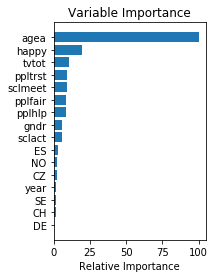

In [5]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!

In [6]:
#make gender feature binary
df.gndr = df.gndr.apply(lambda x: 1 if x == 2.0 else 0)

In [42]:
params = {'n_estimators': 100,
              'max_depth': 8,
              'loss': 'exponential'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

#create dataframe of observations that were True Positives
tp_index = [i for i,_ in enumerate(predict_test) if (predict_test[i] == 1) and (y_test.iloc[i] == 1)]
tp_data = X_test.iloc[tp_index]

tn_index = [i for i,_ in enumerate(predict_test) if (predict_test[i] == 0) and (y_test.iloc[i] == 0)]
tn_data = X_test.iloc[tn_index]

#create dataframe of observatons that were Type I errors (False Negatives)
t_I_index = [i for i,_ in enumerate(predict_test) if (predict_test[i] == 1) and (y_test.iloc[i] == 0)]
t_I_data = X_test.iloc[t_I_index]

#create dataframe of observatons that were Type II errors (False Negatives)
t_II_index = [i for i,_ in enumerate(predict_test) if (predict_test[i] == 0) and (y_test.iloc[i] == 1)]
t_II_data = X_test.iloc[t_II_index]

        
# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.0015580736543909348
Percent Type II errors: 0.0575070821529745

Test set accuracy:
Percent Type I errors: 0.08588957055214724
Percent Type II errors: 0.18527607361963191


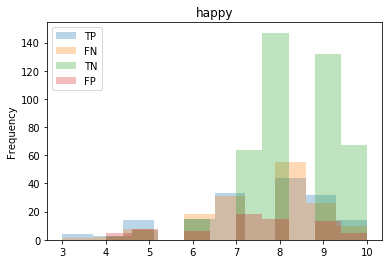

Ttest_indResult(statistic=-0.5875170108090418, pvalue=0.5572869932689841)


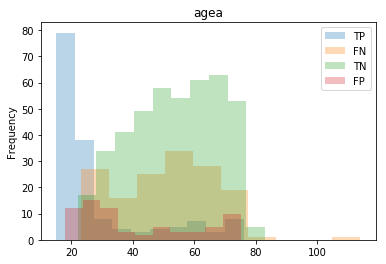

Ttest_indResult(statistic=-12.569097227342997, pvalue=1.5755639802655142e-29)


In [43]:
#plot the distribution for True Postives and Type II observations in each column
for col in ['happy','agea']:
    
    bx = tp_data[col].plot(kind='hist', alpha=.3)
    ax = t_II_data[col].plot(kind='hist',alpha=.3)
    vx = tn_data[col].plot(kind='hist',alpha=.3)
    nx = t_I_data[col].plot(kind='hist',alpha=.3)
    plt.legend(['TP', 'FN', 'TN', 'FP'])
    plt.title(col)
    
    plt.show()
    
    print(stats.ttest_ind(tp_data[col], t_II_data[col]))

There is a significant difference between the false negative and true positive age distrubtion. The age range for true postives was 15-29 years old. The age range of false negatives were 26-78 years old. The classifier is somewhat able to correctly classify positve observations between 26-29 years old and is not able to correctly classfiy postive observations higher than 29 years old. As we saw above, the age feature is the most important feature that contributes to the model prediction, so the main cause of false negatives could be solved within the age feature. 

There are two solutions to this problem:

Down sample the majority class (no partner) within the false negative age range. 
Create synthetic data of the minority class (false negatives) that would counter balances the majority class.


In [72]:
import random
down_sample_idx = list(df.loc[(df.partner == 1) & (df.agea < 83)].index)[:2000]
down_sample_df = df.drop(df.index[down_sample_idx])

In [73]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(down_sample_df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])], down_sample_df['partner']-1)



In [78]:
params = {'n_estimators': 500,
              'max_depth': 4,
              'loss': 'exponential'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(train_x, train_y)
predict_train = clf.predict(train_x)
predict_test = clf.predict(test_x)

        
# Accuracy tables.
table_train = pd.crosstab(train_y, predict_train, margins=True)
table_test = pd.crosstab(test_y, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.019522776572668113
Percent Type II errors: 0.1017353579175705

Test set accuracy:
Percent Type I errors: 0.08067664281067013
Percent Type II errors: 0.1730644111906311


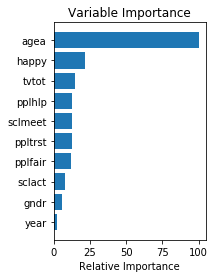

In [79]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()